In [1]:
import qdrant_client
import matplotlib.pyplot as plt
import os

from PIL import Image
from llama_index.core import StorageContext, SimpleDirectoryReader, Settings
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.vector_stores.qdrant import QdrantVectorStore

/opt/anaconda3/envs/dev11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

# Retrieval


In [3]:
# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

text_store = QdrantVectorStore(client=client, collection_name="text_collection")
image_store = QdrantVectorStore(client=client, collection_name="image_collection")

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

In [4]:
import json

json_documents = json.load(
    open("./output/text/survive-100-days-trapped-win-500000.json")
)
text = ""
for chunk in json_documents["chunks"]:
    ts = chunk["timestamp"]

    text += str(ts[0]) + ": "
    text += chunk["text"].replace("\n", " ") + "\n"

with open("./output/transcription/survive-100-days-trapped-win-500000.txt", "w") as f:
    f.write(text)

In [4]:
img_documents = SimpleDirectoryReader("./output/img").load_data()
text_documents = SimpleDirectoryReader("./output/transcription").load_data()

all_documents = img_documents + text_documents
# all_documents = SimpleDirectoryReader("output/mixed").load_data()

index = MultiModalVectorStoreIndex.from_documents(
    all_documents,
    storage_context=storage_context,
    embed_model=HuggingFaceEmbedding(
        model_name="BAAI/bge-large-en-v1.5"
    ),  # BAAI/bge-base-en-v1.5
    show_progress=True,
)

# index.storage_context.persist(persist_dir="./storage")

Generating image embeddings: 100%|██████████| 326/326 [01:42<00:00,  3.19it/s]


In [7]:
# Load it
# from llama_index.core import load_index_from_storage

# storage_context = StorageContext.from_defaults(
#     vector_store=text_store, persist_dir="./storage"
# )
# index = load_index_from_storage(storage_context, image_store=image_store, embed_model=HuggingFaceEmbedding(model_name="BAAI/bge-large-en-v1.5"))

In [17]:
retriever_engine = index.as_retriever(similarity_top_k=5, image_similarity_top_k=3)

In [8]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode


def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

In [18]:
query_str = 'Get all the sentences contain the word "Tesla" and its timestamp.'

img, txt = retrieve(retriever_engine=retriever_engine, query_str=query_str)

**Node ID:** 40957aed-f828-4220-a6b6-6e0dfc50e38b<br>**Similarity:** 0.631217015739816<br>**Text:** 920.79: Is either going to be
921.42: the best moment of their life or the worst moment.
923.76: Just give me your answer in an hour.
925.22: All right, Thanks. We'll be thinking.
926.56: 59 minute...<br>

**Node ID:** 5e7b90ca-87a1-41ab-a09e-b30a738cdc26<br>**Similarity:** 0.6006253030932417<br>**Text:** 663.23: You should be able to use your coffee pot again, cook food.
665.73: You should have a hot shower.
666.97: That's excellent.
667.83: I'll see you tomorrow with the surprise.
669.2: Oh, I'm s...<br>

**Node ID:** 57ca09ff-a746-476d-858a-cc739483724c<br>**Similarity:** 0.599695372839322<br>**Text:** 1519.22: All right. throw the music back in his ears.
1521.95: What if while we were over there, he was like,
1523.56: "Oh, this is a no brainer. It's too much money"
1525.26: We would never speak ...<br>

**Node ID:** 3ee17bfd-dc8a-475e-865c-2ee32582c2c1<br>**Similarity:** 0.5971663752246212<br>**Text:** 1404.17: Ever
1406.17: 24 hours remain.
1408.24: - This many. - Yes.
1410.17: So this is the first second of the challenge when you've both walked in.
1413.81: - Oh, my Gosh. - How was that us?
141...<br>

**Node ID:** 4e54484d-ef75-42b8-bf31-5a29d0542991<br>**Similarity:** 0.5911560446599045<br>**Text:** 539.3: And on day 28, Bailey clearly needed entertainment.
545.08: So by day 30
545.88: I had the perfect plan to get them to spend money.
548.48: It's now day 30 and it's time for another offer.
5...<br>

In [19]:
txt

["920.79: Is either going to be\n921.42: the best moment of their life or the worst moment.\n923.76: Just give me your answer in an hour.\n925.22: All right, Thanks. We'll be thinking.\n926.56: 59 minutes remain in.\n928.33: I think we should.\n929.23: I know, I think it might be worth it.\n931.23: Imagine it is something great and we said no.\n933.26: Would it ever be a car?\n934.97: Well, it could be. Could actually be the keys to a car.\n937.27: It's not going to be equal to the value that we're spending.\n940.14: She's right. It's almost three times more.\n941.74: I don't feel confident in the yes.\n944.14: Then let's say no.\n944.98: But are you sure?\n945.98: Yeah, if you're not confident.\n947.25: I just know they would never do a car.\n950.15: - Yeah, they would. - Really?\n951.28: Yeah I feel like they could do anything. Let's just say no.\n953.45: Wait, now you have me wanting to say yes.\n957.06: Decision time.\n958.12: Okay.\n958.76: Do you want to spend $50,000 to keep wha

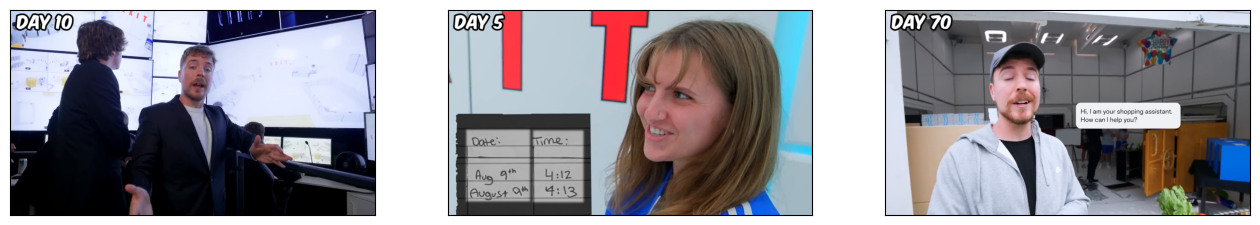

In [20]:
plot_images(img)

# Generation


In [12]:
import json
import google.generativeai as genai
from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls
from llama_index.core import PromptTemplate
from llama_index.core.schema import QueryBundle

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [13]:
gemini = GeminiMultiModal(model_name="models/gemini-pro-vision")

video_metadata = json.load(
    open("./output/metadata/survive-100-days-trapped-win-500000.json")
)

In [14]:
qa_tmpl_str = (
    f"You have the images and transcription from a video called \"{video_metadata['title']}\""
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=gemini, text_qa_template=qa_tmpl, similarity_top_k=3, image_similarity_top_k=3
)

In [27]:
def chat(query_str: QueryBundle | str, print_retrieval_result: bool = True):
    response = query_engine.query(query_str)
    print(f"Assistant:\n{str(response)}")

    if print_retrieval_result:
        for text_node in response.metadata["text_nodes"]:
            display_source_node(text_node, source_length=2000)
        plot_images([n.metadata["file_path"] for n in response.metadata["image_nodes"]])
    return response

Assistant:
 - Here is a Tesla key for you and a Tesla key for you. (983.01)
- I'm so sorry. (987.95)
- They would have gotten their money back. (989.82)
- Plus these two Teslas for free. (991.29)
- They got us Teslas. (1007.24)
- I feel like we made the wrong decision. (1009.61)
- I'll regret this forever. (1011.48)
- There, I said it. (1020.02)
- It's really hard to see the positive in all this. (1026.03)
- I actually won't be able to sleep. (1031.13)
- I'm actually feeling sick right now. (1033.01)
- I'm so mad. (1036.7)
- And so to make up for it, (1040.54)
- I made sure this next offer was the best one yet. (1041.47)
- What you see here is everything you said no to so far in this challenge. (1063.33)
- There's 30 seconds left in the challenge at the very last second. (1550.15)
- You both chose split! (1592.79)
- You can say like a Tesla, Yu-Gi-Oh cards. (1616.65)


**Node ID:** 40957aed-f828-4220-a6b6-6e0dfc50e38b<br>**Similarity:** 0.6199764104053835<br>**Text:** 920.79: Is either going to be
921.42: the best moment of their life or the worst moment.
923.76: Just give me your answer in an hour.
925.22: All right, Thanks. We'll be thinking.
926.56: 59 minutes remain in.
928.33: I think we should.
929.23: I know, I think it might be worth it.
931.23: Imagine it is something great and we said no.
933.26: Would it ever be a car?
934.97: Well, it could be. Could actually be the keys to a car.
937.27: It's not going to be equal to the value that we're spending.
940.14: She's right. It's almost three times more.
941.74: I don't feel confident in the yes.
944.14: Then let's say no.
944.98: But are you sure?
945.98: Yeah, if you're not confident.
947.25: I just know they would never do a car.
950.15: - Yeah, they would. - Really?
951.28: Yeah I feel like they could do anything. Let's just say no.
953.45: Wait, now you have me wanting to say yes.
957.06: Decision time.
958.12: Okay.
958.76: Do you want to spend $50,000 to keep what is inside this box?
963.2: Yes or no?
964.6: No.
965.4: Really?
966.63: What is your answer?
967.77: I'm going with no.
969.03: - Really? - Yeah.
969.93: I can't believe you guys didn't take it.
971.97: - Do you want to unlock it? - Sure.
975.34: All right, inside is $50,000, so you would have got your money back.
980.48: And then you want to open up that stack of money. Just grab that.
983.01: Here is a Tesla key for you and a Tesla key for you.
987.95: I'm so sorry.
989.82: They would have gotten their money back.
991.29: Plus these two Teslas for free.
993.56: Oh, I want to cry.
994.86: Let's close this.
997.73: That's literally my dream.
999.26: We're going to head out.
1000.13: You leave their Beef. Thank you.
1001.97:  Bye.
1003.47: - I feel defeated. - That's wild.
1005.7: Bailey...
1007.24: They got us Teslas.
1009.61: I feel like we made the wrong decision.
1011.48: I'll regret this forever.
1013.01: - No. - Yeah, I will.
1015.31: Oh, no, it's all a dream.
1018.28: I like my Prius. Okay?
1020.02...<br>

**Node ID:** 57ca09ff-a746-476d-858a-cc739483724c<br>**Similarity:** 0.5899638458917463<br>**Text:** 1519.22: All right. throw the music back in his ears.
1521.95: What if while we were over there, he was like,
1523.56: "Oh, this is a no brainer. It's too much money"
1525.26: We would never speak again.
1526.29: You guys have become, like, such close friends.
1528.23: I don't know. You get to know anyone.
1529.76: And when you've gone through the same thing
1532.4: and like how hard this challenge has been, we both deserve half for sure.
1536.57: But now you're making me nervous.
1538.64: Like I could do it, too.
1541.17: What did she just say?
1542.24: Maybe it'll be a case of you thinking of someone.
1544.51: I don't know.
1545.21: If both of them press the steal button,
1546.68: they literally spend 100 days in this room together
1549.08: for absolutely nothing.
1550.15: There's 30 seconds left in the challenge at the very last second.
1553.68: I want you both to place your vote.
1555.75: Do you want to walk away with 360 grand or half of it?
1559.32: No one speak.
1560.06: Karl and Kris, you two don't talk either.
1561.89: I know that Suzie is going to split, but the thought of walking away
1565.16: with almost $360,000, I could do so much.
1569.63: Do you want to split the money or steal it?
1571.57: The fact that I entered this challenge,
1573.24: Three.
1573.94: Knowing that
1575.24: there would be pretty dark times ahead
1577.38: Two.
1578.14: And I still overcame all those things
1580.38: One.
1581.15: There's no price you can put on that.
1584.92: No way.
1585.92: If the room turns red, then someone stole.
1588.89: If the room turns green, then you split the money.
1592.79: You both chose split!
1594.16: Yes!
1595.89: Yes!
1597.03: Congratulations on surviving!
1598.86: - Yeah! - Yes!
1599.73: There you go, there's your money! Follow me out here.
1605.94: And like I said earlier in the video, don't
1607.37: forget to download the Shop app.
1608.64: If you go on my store in the Shop app,
1610.28: you can tell me whatever you want for the holiday.
1611.9...<br>

**Node ID:** 4e54484d-ef75-42b8-bf31-5a29d0542991<br>**Similarity:** 0.5846825676746683<br>**Text:** 539.3: And on day 28, Bailey clearly needed entertainment.
545.08: So by day 30
545.88: I had the perfect plan to get them to spend money.
548.48: It's now day 30 and it's time for another offer.
550.58: - How's it going? - Hi.
552.49: Today's offer is simple.
553.85: Each of these five items cost $10,000.
556.25: You can buy one phone call, the entire Harry Potter collection,
559.62: your own coffee machine, spices, salt and pepper for your food.
562.89: Or you can buy a monopoly for $10,000.
565.1: You could buy one of them. You can buy all five of them.
567.13: This is tough, actually. You have 10 minutes to decide.
569.87: Just let me know what you want.
570.8: I'm so nervous.
571.64: - This is a big decision. - Coffee?
574.17: - It does sound kind of nice. - It does.
576.48: - And then the seasoning. - Seasoning sounds nice too.
578.64: I'm doing this one 1,000% I'll be honest with you.
581.25: I don't really care about that.
582.72: Sick.
583.25: Coffee would be nice,
584.82: as like a treat every morning.
586.42: I've made my mind up.
588.32: Decision time.
590.09: Are you buying Monopoly?
591.52: - No. - No.
592.09: Gone.
594.06: Are you buying the spices?
595.19: - No. - No.
598.23: Are you buying the coffee?
599.26: Does it come with cream or sugar?
601.13: If you say yes in 3 seconds.
604.2: - Yes. - Okay.
606.47: Yay Coffee!
607.74: Are you buying the Harry Potter books?
609.17: Yes.
611.61: Are you buying the phone calls?
612.68: - No. - No.
614.75: We finally got you two to buy something.
617.65: This feels good. It was a pleasure doing business.
619.99: Thanks for taking your money.
621.22: Most expensive coffee maker in the world.
623.46: 30 days in, we got something new, that's exciting.
625.59: We caved. You're welcome.
627.06: That's my closet.
628.26: That's my bookshelf.
629.36: I could stay another 70 days easy.
631.33: And we still have $480,000 It’s crazy.
634.23: Over the next few days.
635.5: Not a lot happened.
636.6: - She's already pr...<br>

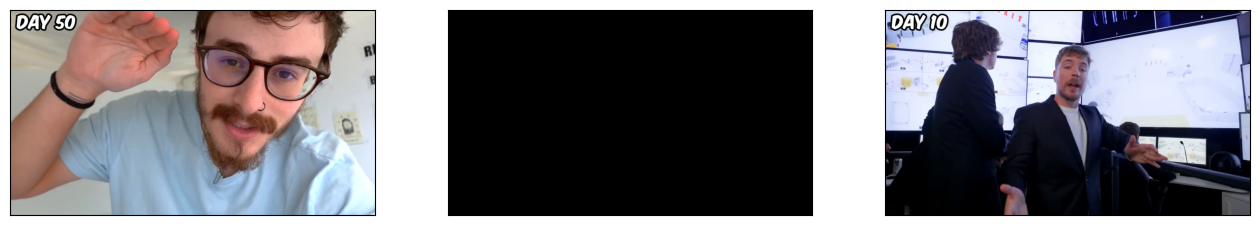

In [22]:
response = chat(
    'Get all the sentences contain the word "Tesla" and its timestamp. Response with only the sentence with the word "Tesla".'
)

Assistant:
 The prize is $500,000.


**Node ID:** 57ca09ff-a746-476d-858a-cc739483724c<br>**Similarity:** 0.529769987207489<br>**Text:** 1519.22: All right. throw the music back in his ears.
1521.95: What if while we were over there, he was like,
1523.56: "Oh, this is a no brainer. It's too much money"
1525.26: We would never speak again.
1526.29: You guys have become, like, such close friends.
1528.23: I don't know. You get to know anyone.
1529.76: And when you've gone through the same thing
1532.4: and like how hard this challenge has been, we both deserve half for sure.
1536.57: But now you're making me nervous.
1538.64: Like I could do it, too.
1541.17: What did she just say?
1542.24: Maybe it'll be a case of you thinking of someone.
1544.51: I don't know.
1545.21: If both of them press the steal button,
1546.68: they literally spend 100 days in this room together
1549.08: for absolutely nothing.
1550.15: There's 30 seconds left in the challenge at the very last second.
1553.68: I want you both to place your vote.
1555.75: Do you want to walk away with 360 grand or half of it?
1559.32: No one speak.
1560.06: Karl and Kris, you two don't talk either.
1561.89: I know that Suzie is going to split, but the thought of walking away
1565.16: with almost $360,000, I could do so much.
1569.63: Do you want to split the money or steal it?
1571.57: The fact that I entered this challenge,
1573.24: Three.
1573.94: Knowing that
1575.24: there would be pretty dark times ahead
1577.38: Two.
1578.14: And I still overcame all those things
1580.38: One.
1581.15: There's no price you can put on that.
1584.92: No way.
1585.92: If the room turns red, then someone stole.
1588.89: If the room turns green, then you split the money.
1592.79: You both chose split!
1594.16: Yes!
1595.89: Yes!
1597.03: Congratulations on surviving!
1598.86: - Yeah! - Yes!
1599.73: There you go, there's your money! Follow me out here.
1605.94: And like I said earlier in the video, don't
1607.37: forget to download the Shop app.
1608.64: If you go on my store in the Shop app,
1610.28: you can tell me whatever you want for the holiday.
1611.9...<br>

**Node ID:** 4e54484d-ef75-42b8-bf31-5a29d0542991<br>**Similarity:** 0.5277351649192041<br>**Text:** 539.3: And on day 28, Bailey clearly needed entertainment.
545.08: So by day 30
545.88: I had the perfect plan to get them to spend money.
548.48: It's now day 30 and it's time for another offer.
550.58: - How's it going? - Hi.
552.49: Today's offer is simple.
553.85: Each of these five items cost $10,000.
556.25: You can buy one phone call, the entire Harry Potter collection,
559.62: your own coffee machine, spices, salt and pepper for your food.
562.89: Or you can buy a monopoly for $10,000.
565.1: You could buy one of them. You can buy all five of them.
567.13: This is tough, actually. You have 10 minutes to decide.
569.87: Just let me know what you want.
570.8: I'm so nervous.
571.64: - This is a big decision. - Coffee?
574.17: - It does sound kind of nice. - It does.
576.48: - And then the seasoning. - Seasoning sounds nice too.
578.64: I'm doing this one 1,000% I'll be honest with you.
581.25: I don't really care about that.
582.72: Sick.
583.25: Coffee would be nice,
584.82: as like a treat every morning.
586.42: I've made my mind up.
588.32: Decision time.
590.09: Are you buying Monopoly?
591.52: - No. - No.
592.09: Gone.
594.06: Are you buying the spices?
595.19: - No. - No.
598.23: Are you buying the coffee?
599.26: Does it come with cream or sugar?
601.13: If you say yes in 3 seconds.
604.2: - Yes. - Okay.
606.47: Yay Coffee!
607.74: Are you buying the Harry Potter books?
609.17: Yes.
611.61: Are you buying the phone calls?
612.68: - No. - No.
614.75: We finally got you two to buy something.
617.65: This feels good. It was a pleasure doing business.
619.99: Thanks for taking your money.
621.22: Most expensive coffee maker in the world.
623.46: 30 days in, we got something new, that's exciting.
625.59: We caved. You're welcome.
627.06: That's my closet.
628.26: That's my bookshelf.
629.36: I could stay another 70 days easy.
631.33: And we still have $480,000 It’s crazy.
634.23: Over the next few days.
635.5: Not a lot happened.
636.6: - She's already pr...<br>

**Node ID:** 3ee17bfd-dc8a-475e-865c-2ee32582c2c1<br>**Similarity:** 0.5021627359244105<br>**Text:** 1404.17: Ever
1406.17: 24 hours remain.
1408.24: - This many. - Yes.
1410.17: So this is the first second of the challenge when you've both walked in.
1413.81: - Oh, my Gosh. - How was that us?
1417.08: I feel like I look like I'm a fetus in that.
1419.88: Come on in, gentleman.
1421.05: Set it up right above the door.
1422.72: It's so exciting.
1424.02: You officially have 24 hours left in the challenge.
1427.49: Don't forget what I said.
1428.96: We got a fun twist for tomorrow.
1431.3: I'm scared.
1431.93: You think they'll still be friends after this?
1433.4: Depends what their answer is tomorrow.
1435.37: I'm worried that it's going to be double or nothing.
1438.2: He's so, like, quiet about it.
1439.27: - You can't guess. - Yeah.
1440.37: And with their final night coming to an end,
1442.27: It was time to present them with an opportunity to double their money.
1446.85: Hey, everyone.
1448.65: This is chaotic.
1449.65: What is going on?
1450.92: I don't know.
1452.52: Big boy.
1453.65: I want to help, but not really.
1454.72: They're literally just taking everything.
1458.39: Do you know what these are?
1459.29: Those are blindfolds from the first day.
1460.89: That was quick.
1461.63: I remember it like it was yesterday.
1462.73: If you would both please put them back on.
1464.93: Let's see if they want to double their money.
1466.87: Okay.
1468.67: Oh my gosh, my heart is actually beating out of my chest.
1472.07: 100 days ago, they were strangers.
1473.67: One hour ago they were best friends.
1475.34: Let's see if they become total enemies.
1477.14: Bailey and Suzie,
1478.24: take your blindfolds off.
1480.74: So you might be familiar with what we're about to offer you.
1484.82: You each have the choice to split the money, and nothing changes.
1488.89: You both hit split. You just split it.
1490.49: Keep what you have,
1491.66: or if you hit steal, you can steal the other person's money.
1495.49: And if you both hit steal, you would get nothing.
1498.8: ...<br>

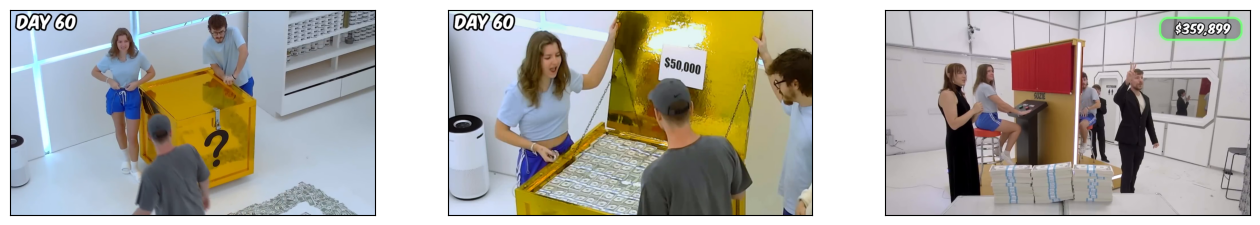

In [23]:
response = chat("What is the prize?")

Assistant:
 The parents of the contestants visited them on day 50 of the challenge.


**Node ID:** 79b0d548-3759-41dc-81e3-68fd1e8156dc<br>**Similarity:** 0.5830587817457993<br>**Text:** 794.36: Tomorrow is day 50, so I'm going to use toilet paper
797.86: to do streamers and decorate the room.
803.8: It's day 50.
805.67: Oh hey!
806.97: So what do you think your surprise is today?
808.84: I have no idea.
810.04: This one is a very big one.
811.84: All right, so the offer for day 50 is $20,000 for you to see your family.
816.01: They're in the other room
816.98: watching that feed and they can hear everything we're saying,
819.59: - Hey, I miss you guys. - Hi! I love you guys.
822.19: I'll be back in 10 minutes to hear if you're going to take the offer.
824.99: Good luck. 10 minutes.
826.16: This is like a pretty easy decision.
827.76: What are your thoughts?
828.59: Oh, my gosh. I don't know.
829.56: This might be the only chance
830.83: in this challenge to see them until the end.
832.73: I think it's a no brainer personally.
834.17: So it's up to you on
835.2: if we spend 20 grand for both.
836.9: Of course. I want to see my parents too.
838.57: It's killing me.
839.67: He is a yes and she is a no.
841.44: Mom, dad, tell me what to do.
843.58: All right.
844.34: What do you think? And where are you guys at?
845.64: He's been a yes from the beginning.
847.18: As soon as you said it.
848.48: About 10 seconds left.
850.01: But it's my mom's birthday today and we're saying yes.
852.15: All right. Give me $20,000 and I'll go get them.
854.02: Best 10K ever spent, I think.
856.19: Okay.
856.92: They paid the 20 grand. Come on in.
859.06: I'm so excited.
866.73: It was a tough decision.
868.8: I made you a birthday gift.
870.4: And to celebrate her birthday, we brought a birthday cake.
876.51: This is the best tasty thing they've had in forever.
879.58: It's little things like that that you don't realize
881.88: you won't have until you're in it.
884.15: Bye! Love you.
885.12: Bye!
886.49: That's the worst feeling so far.
888.69: The highest of highs.
890.09: And now back to our little cube all alone.
894.66: Like I said earlier, the things we're offe...<br>

**Node ID:** bd43cc6b-892b-48eb-a881-2f910c3cb370<br>**Similarity:** 0.5540260607764382<br>**Text:** 146.68: Is he making... Cards?
148.21: All right. So I just finished my deck of cards.
149.68: I think that they actually  came out all right.
151.15: Which honestly looked pretty fun.
152.75: So I made myself a $30,000 seat and joined it.
160.79: On day five, they made a sign in sheet,
162.63: which was really just an elaborate trick.
164.76: What is it?
165.3: You have to sign our sign in sheet.
167.23: Oh, these are our camera people.
168.4: Yeah, this is everyone  that's come in today.
170.3: Wait a minute.
171.34: You're having them do this
172.34: so you can track the date and the time.
175.11: Hold up, I need to borrow this.
176.64: No, no, I wrote the date.
178.01: I wrote the date.
178.81: Which I got to say was pretty smart.
180.58: But by the time we got to day seven,
182.35: anything considered smart was thrown out the window.
185.38: Bailey's lost it.
187.85: He's whipping the pork.
191.39: Yeah.
192.16: The veggies never stood a chance.
194.86: Five more throws.
196.96: But I only need one.
198.63: Let's freakin go, baby.
200.13: It's actually crazy to me that already on day 9
202.63: of this challenge, they're bored enough to expose the red line
206.54: that if they cross, they lose every dollar of their prize money.
211.11: It is now day number ten.
212.58: How you doing, Nolan?
213.55: Good.
214.51: And I got a pretty interesting offer.
216.05: What is it?
219.59: So it looks like they took the $500,000 and put 250 on her side
223.46: and 250 on his to remind themselves of what's at stake.
227.49: The whole door opening thing is so dramatic.
229.93: How's it going?
230.73: We're about to reveal the most interesting part of the challenge.
233.3: I need you two to just face this wall.
235.67: They don't even know that there's a door back here.
237.94: Let's do this.
244.74: This is their first time seeing the outside world in 10 days.
247.78: You are kidding me.
251.08: The sky.
252.38: Every ten days, I will give you something
254.52: that will ma...<br>

**Node ID:** 57ca09ff-a746-476d-858a-cc739483724c<br>**Similarity:** 0.5431912975199673<br>**Text:** 1519.22: All right. throw the music back in his ears.
1521.95: What if while we were over there, he was like,
1523.56: "Oh, this is a no brainer. It's too much money"
1525.26: We would never speak again.
1526.29: You guys have become, like, such close friends.
1528.23: I don't know. You get to know anyone.
1529.76: And when you've gone through the same thing
1532.4: and like how hard this challenge has been, we both deserve half for sure.
1536.57: But now you're making me nervous.
1538.64: Like I could do it, too.
1541.17: What did she just say?
1542.24: Maybe it'll be a case of you thinking of someone.
1544.51: I don't know.
1545.21: If both of them press the steal button,
1546.68: they literally spend 100 days in this room together
1549.08: for absolutely nothing.
1550.15: There's 30 seconds left in the challenge at the very last second.
1553.68: I want you both to place your vote.
1555.75: Do you want to walk away with 360 grand or half of it?
1559.32: No one speak.
1560.06: Karl and Kris, you two don't talk either.
1561.89: I know that Suzie is going to split, but the thought of walking away
1565.16: with almost $360,000, I could do so much.
1569.63: Do you want to split the money or steal it?
1571.57: The fact that I entered this challenge,
1573.24: Three.
1573.94: Knowing that
1575.24: there would be pretty dark times ahead
1577.38: Two.
1578.14: And I still overcame all those things
1580.38: One.
1581.15: There's no price you can put on that.
1584.92: No way.
1585.92: If the room turns red, then someone stole.
1588.89: If the room turns green, then you split the money.
1592.79: You both chose split!
1594.16: Yes!
1595.89: Yes!
1597.03: Congratulations on surviving!
1598.86: - Yeah! - Yes!
1599.73: There you go, there's your money! Follow me out here.
1605.94: And like I said earlier in the video, don't
1607.37: forget to download the Shop app.
1608.64: If you go on my store in the Shop app,
1610.28: you can tell me whatever you want for the holiday.
1611.9...<br>

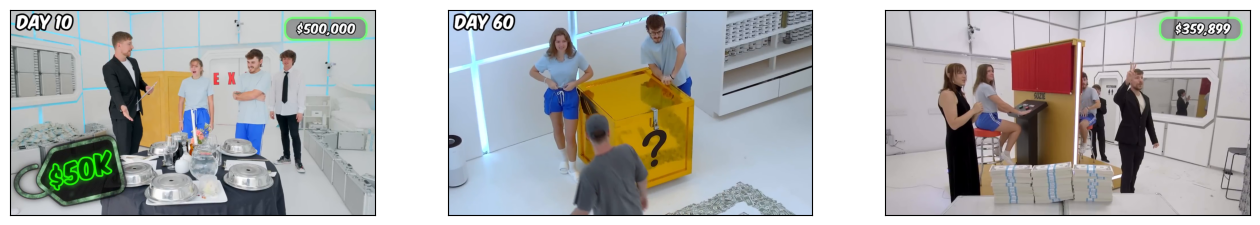

In [24]:
response = chat("When did the parent of the contestants visit them?")

Assistant:
 Yes, they won the prize. The image shows the contestants on day 99 and day 100. On day 100, they are shown exiting the room, indicating they have won the prize.


**Node ID:** 57ca09ff-a746-476d-858a-cc739483724c<br>**Similarity:** 0.6864473444729184<br>**Text:** 1519.22: All right. throw the music back in his ears.
1521.95: What if while we were over there, he was like,
1523.56: "Oh, this is a no brainer. It's too much money"
1525.26: We would never speak again.
1526.29: You guys have become, like, such close friends.
1528.23: I don't know. You get to know anyone.
1529.76: And when you've gone through the same thing
1532.4: and like how hard this challenge has been, we both deserve half for sure.
1536.57: But now you're making me nervous.
1538.64: Like I could do it, too.
1541.17: What did she just say?
1542.24: Maybe it'll be a case of you thinking of someone.
1544.51: I don't know.
1545.21: If both of them press the steal button,
1546.68: they literally spend 100 days in this room together
1549.08: for absolutely nothing.
1550.15: There's 30 seconds left in the challenge at the very last second.
1553.68: I want you both to place your vote.
1555.75: Do you want to walk away with 360 grand or half of it?
1559.32: No one speak.
1560.06: Karl and Kris, you two don't talk either.
1561.89: I know that Suzie is going to split, but the thought of walking away
1565.16: with almost $360,000, I could do so much.
1569.63: Do you want to split the money or steal it?
1571.57: The fact that I entered this challenge,
1573.24: Three.
1573.94: Knowing that
1575.24: there would be pretty dark times ahead
1577.38: Two.
1578.14: And I still overcame all those things
1580.38: One.
1581.15: There's no price you can put on that.
1584.92: No way.
1585.92: If the room turns red, then someone stole.
1588.89: If the room turns green, then you split the money.
1592.79: You both chose split!
1594.16: Yes!
1595.89: Yes!
1597.03: Congratulations on surviving!
1598.86: - Yeah! - Yes!
1599.73: There you go, there's your money! Follow me out here.
1605.94: And like I said earlier in the video, don't
1607.37: forget to download the Shop app.
1608.64: If you go on my store in the Shop app,
1610.28: you can tell me whatever you want for the holiday.
1611.9...<br>

**Node ID:** 79b0d548-3759-41dc-81e3-68fd1e8156dc<br>**Similarity:** 0.6840073614801394<br>**Text:** 794.36: Tomorrow is day 50, so I'm going to use toilet paper
797.86: to do streamers and decorate the room.
803.8: It's day 50.
805.67: Oh hey!
806.97: So what do you think your surprise is today?
808.84: I have no idea.
810.04: This one is a very big one.
811.84: All right, so the offer for day 50 is $20,000 for you to see your family.
816.01: They're in the other room
816.98: watching that feed and they can hear everything we're saying,
819.59: - Hey, I miss you guys. - Hi! I love you guys.
822.19: I'll be back in 10 minutes to hear if you're going to take the offer.
824.99: Good luck. 10 minutes.
826.16: This is like a pretty easy decision.
827.76: What are your thoughts?
828.59: Oh, my gosh. I don't know.
829.56: This might be the only chance
830.83: in this challenge to see them until the end.
832.73: I think it's a no brainer personally.
834.17: So it's up to you on
835.2: if we spend 20 grand for both.
836.9: Of course. I want to see my parents too.
838.57: It's killing me.
839.67: He is a yes and she is a no.
841.44: Mom, dad, tell me what to do.
843.58: All right.
844.34: What do you think? And where are you guys at?
845.64: He's been a yes from the beginning.
847.18: As soon as you said it.
848.48: About 10 seconds left.
850.01: But it's my mom's birthday today and we're saying yes.
852.15: All right. Give me $20,000 and I'll go get them.
854.02: Best 10K ever spent, I think.
856.19: Okay.
856.92: They paid the 20 grand. Come on in.
859.06: I'm so excited.
866.73: It was a tough decision.
868.8: I made you a birthday gift.
870.4: And to celebrate her birthday, we brought a birthday cake.
876.51: This is the best tasty thing they've had in forever.
879.58: It's little things like that that you don't realize
881.88: you won't have until you're in it.
884.15: Bye! Love you.
885.12: Bye!
886.49: That's the worst feeling so far.
888.69: The highest of highs.
890.09: And now back to our little cube all alone.
894.66: Like I said earlier, the things we're offe...<br>

**Node ID:** 3ee17bfd-dc8a-475e-865c-2ee32582c2c1<br>**Similarity:** 0.6810834802641654<br>**Text:** 1404.17: Ever
1406.17: 24 hours remain.
1408.24: - This many. - Yes.
1410.17: So this is the first second of the challenge when you've both walked in.
1413.81: - Oh, my Gosh. - How was that us?
1417.08: I feel like I look like I'm a fetus in that.
1419.88: Come on in, gentleman.
1421.05: Set it up right above the door.
1422.72: It's so exciting.
1424.02: You officially have 24 hours left in the challenge.
1427.49: Don't forget what I said.
1428.96: We got a fun twist for tomorrow.
1431.3: I'm scared.
1431.93: You think they'll still be friends after this?
1433.4: Depends what their answer is tomorrow.
1435.37: I'm worried that it's going to be double or nothing.
1438.2: He's so, like, quiet about it.
1439.27: - You can't guess. - Yeah.
1440.37: And with their final night coming to an end,
1442.27: It was time to present them with an opportunity to double their money.
1446.85: Hey, everyone.
1448.65: This is chaotic.
1449.65: What is going on?
1450.92: I don't know.
1452.52: Big boy.
1453.65: I want to help, but not really.
1454.72: They're literally just taking everything.
1458.39: Do you know what these are?
1459.29: Those are blindfolds from the first day.
1460.89: That was quick.
1461.63: I remember it like it was yesterday.
1462.73: If you would both please put them back on.
1464.93: Let's see if they want to double their money.
1466.87: Okay.
1468.67: Oh my gosh, my heart is actually beating out of my chest.
1472.07: 100 days ago, they were strangers.
1473.67: One hour ago they were best friends.
1475.34: Let's see if they become total enemies.
1477.14: Bailey and Suzie,
1478.24: take your blindfolds off.
1480.74: So you might be familiar with what we're about to offer you.
1484.82: You each have the choice to split the money, and nothing changes.
1488.89: You both hit split. You just split it.
1490.49: Keep what you have,
1491.66: or if you hit steal, you can steal the other person's money.
1495.49: And if you both hit steal, you would get nothing.
1498.8: ...<br>

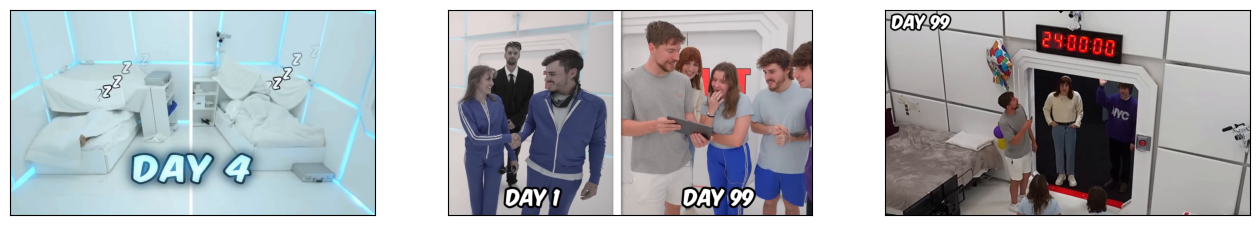

In [25]:
response = chat("What is the result at day 100? Did they win the prize?")

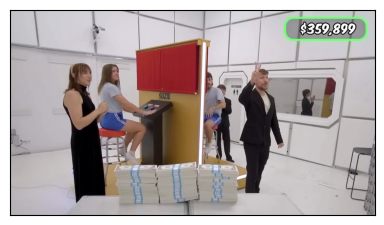

In [57]:
plot_images(
    [
        "/Users/minhquang/Desktop/spaces/eklipse/output/img/survive-100-days-trapped-win-500000-frame-0316.png"
    ]
)

In [55]:
query = QueryBundle(
    query_str="What is the timestamp of this scene?",
    image_path="/Users/minhquang/Desktop/spaces/eklipse/output/img/survive-100-days-trapped-win-500000-frame-0316.png",
)

Assistant:  The timestamp of this scene is 1592.79.


**Node ID:** 3d9e5f43-154a-431e-a316-22d9cf48bf67<br>**Similarity:** 0.6508936269763991<br>**Text:** 663.23: You should be able to use your coffee pot again, cook food.
665.73: You should have a hot shower.
666.97: That's excellent.
667.83: I'll see you tomorrow with the surprise.
669.2: Oh, I'm so excited.
671.64: The power's on.
672.57: Look, it's light.
673.74: Like it feels like cheerier.
675.27: The lights are back on again.
677.14: I just had a hot meal, hot shower.
680.78: Life is finally looking up here.
683.65: There's now day 40.
685.92: - Can I come in? - Come in.
687.72: Your gift at no expense is this TV.
691.02: But every single movie is $10,000 a pop.
693.93: You have one hour to decide. Have fun.
696.06: This is crazy. The amount of movies in here.
698.06: We can watch this documentary about Nolan.
701.17: We left Suzie and Bailey to discuss the offer
703.3: and told them we'd be back later, but they didn't seem too interested.
706.4: How about ten grand for all?
707.71: I'll go ahead and tell you now, no.
710.28: You might as well just come in here, because I think we both are
713.91: set in our ways.
715.65: Okay.
716.32: The best I could do is buy one, get one half off.
720.45: Can't do it.
721.32: All right gang, come on in.
722.65: Take every last one.
723.99: I'll gladly keep this.
725.36: Not any of the Hunger Games?
728.19: I left the TV in the chamber to remind Suzie and Bailey
730.63: of what they could have had.
731.56: But little did I know they were going to outsmart me.
734.2: An antenna is just a piece of metal.
735.67: Rip this little wire off the wall.
738.47: So I had to take this knife so that the wire is, like, frayed.
741.81: I literally just plugged it into the antenna spot.
744.41: Now we're going to see if it works.
745.98: Just anything.
746.91: Give us one channel.
749.25: What?
749.98: It says that there's seven digital channels.
751.95: Oh, my gosh.
752.95: If this actually works...
756.89: Wait.
757.79: - I'm like actually shaking. - Bailey!
759.36: Currently the only thing that we can get on the TV
761.26: is a race ...<br>

**Node ID:** 88a11b28-2a40-410b-8e99-6df6241f5fe8<br>**Similarity:** 0.6482298702848439<br>**Text:** 1404.17: Ever
1406.17: 24 hours remain.
1408.24: - This many. - Yes.
1410.17: So this is the first second of the challenge when you've both walked in.
1413.81: - Oh, my Gosh. - How was that us?
1417.08: I feel like I look like I'm a fetus in that.
1419.88: Come on in, gentleman.
1421.05: Set it up right above the door.
1422.72: It's so exciting.
1424.02: You officially have 24 hours left in the challenge.
1427.49: Don't forget what I said.
1428.96: We got a fun twist for tomorrow.
1431.3: I'm scared.
1431.93: You think they'll still be friends after this?
1433.4: Depends what their answer is tomorrow.
1435.37: I'm worried that it's going to be double or nothing.
1438.2: He's so, like, quiet about it.
1439.27: - You can't guess. - Yeah.
1440.37: And with their final night coming to an end,
1442.27: It was time to present them with an opportunity to double their money.
1446.85: Hey, everyone.
1448.65: This is chaotic.
1449.65: What is going on?
1450.92: I don't know.
1452.52: Big boy.
1453.65: I want to help, but not really.
1454.72: They're literally just taking everything.
1458.39: Do you know what these are?
1459.29: Those are blindfolds from the first day.
1460.89: That was quick.
1461.63: I remember it like it was yesterday.
1462.73: If you would both please put them back on.
1464.93: Let's see if they want to double their money.
1466.87: Okay.
1468.67: Oh my gosh, my heart is actually beating out of my chest.
1472.07: 100 days ago, they were strangers.
1473.67: One hour ago they were best friends.
1475.34: Let's see if they become total enemies.
1477.14: Bailey and Suzie,
1478.24: take your blindfolds off.
1480.74: So you might be familiar with what we're about to offer you.
1484.82: You each have the choice to split the money, and nothing changes.
1488.89: You both hit split. You just split it.
1490.49: Keep what you have,
1491.66: or if you hit steal, you can steal the other person's money.
1495.49: And if you both hit steal, you would get nothing.
1498.8: ...<br>

**Node ID:** 731c8cc8-dcef-435b-b873-8dd3597ea6ca<br>**Similarity:** 0.6355485360776123<br>**Text:** 1519.22: All right. throw the music back in his ears.
1521.95: What if while we were over there, he was like,
1523.56: "Oh, this is a no brainer. It's too much money"
1525.26: We would never speak again.
1526.29: You guys have become, like, such close friends.
1528.23: I don't know. You get to know anyone.
1529.76: And when you've gone through the same thing
1532.4: and like how hard this challenge has been, we both deserve half for sure.
1536.57: But now you're making me nervous.
1538.64: Like I could do it, too.
1541.17: What did she just say?
1542.24: Maybe it'll be a case of you thinking of someone.
1544.51: I don't know.
1545.21: If both of them press the steal button,
1546.68: they literally spend 100 days in this room together
1549.08: for absolutely nothing.
1550.15: There's 30 seconds left in the challenge at the very last second.
1553.68: I want you both to place your vote.
1555.75: Do you want to walk away with 360 grand or half of it?
1559.32: No one speak.
1560.06: Karl and Kris, you two don't talk either.
1561.89: I know that Suzie is going to split, but the thought of walking away
1565.16: with almost $360,000, I could do so much.
1569.63: Do you want to split the money or steal it?
1571.57: The fact that I entered this challenge,
1573.24: Three.
1573.94: Knowing that
1575.24: there would be pretty dark times ahead
1577.38: Two.
1578.14: And I still overcame all those things
1580.38: One.
1581.15: There's no price you can put on that.
1584.92: No way.
1585.92: If the room turns red, then someone stole.
1588.89: If the room turns green, then you split the money.
1592.79: You both chose split!
1594.16: Yes!
1595.89: Yes!
1597.03: Congratulations on surviving!
1598.86: - Yeah! - Yes!
1599.73: There you go, there's your money! Follow me out here.
1605.94: And like I said earlier in the video, don't
1607.37: forget to download the Shop app.
1608.64: If you go on my store in the Shop app,
1610.28: you can tell me whatever you want for the holiday.
1611.9...<br>

Response(response=' The timestamp of this scene is 1592.79.', source_nodes=[NodeWithScore(node=TextNode(id_='3d9e5f43-154a-431e-a316-22d9cf48bf67', embedding=None, metadata={'file_path': '/Users/minhquang/Desktop/spaces/eklipse/output/transcription/survive-100-days-trapped-win-500000.txt', 'file_name': 'survive-100-days-trapped-win-500000.txt', 'file_type': 'text/plain', 'file_size': 32886, 'creation_date': '2024-03-23', 'last_modified_date': '2024-03-23'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='af9bcfb4-9f66-46ed-bf32-acb479095764', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/Users/minhquang/Desktop/spaces/eklipse/output/transcription/survive-100-days-trapped-win-500000.txt', 'f

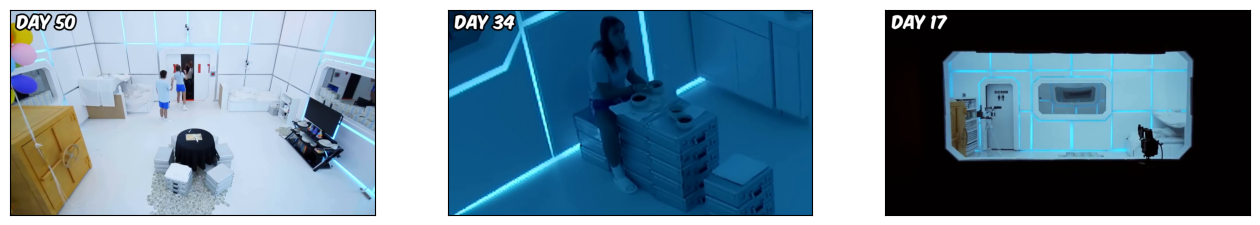

In [56]:
chat(query)

# Gradio app


In [29]:
import gradio as gr

In [ ]:
demo = None

In [63]:
def on_upload_file(filepath):
    pass


def send_message(message, history):
    print(message)
    text = message["text"]

    file = None
    if len(message["files"]):
        file = message["files"][0]["path"]

    response = chat(
        QueryBundle(query_str=text, image_path=file), print_retrieval_result=False
    )
    return str(response)


try:
    with gr.Blocks() as demo:
        with gr.Row():
            with gr.Column(scale=3):
                youtube_url = gr.Textbox(
                    label="Paste in Youtube URL",
                    show_copy_button=True,
                    placeholder="https://www.youtube.com/watch?v=9RhWXPcKBI8",
                )
                gr.Markdown("**OR** upload your video")
                video_upload = gr.UploadButton(
                    label="Select video", file_types=["video"], size="sm"
                )
            with gr.Column(scale=7):
                gr.ChatInterface(send_message, title="Youtube QA", multimodal=True)

        # video_upload.upload()

    demo.launch(share=True)
except:
    demo.close()

Running on local URL:  http://127.0.0.1:7875


python(37399) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running on public URL: https://15d5b320fdfb9a7cda.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


{'text': 'What is this video about?', 'files': []}
Assistant:
 The video is about two strangers who are locked in a white cube for 100 days. They are given enough food and water to last them the entire time, but they have no contact with the outside world. The only way they can communicate with each other is through a small window in the door of the cube.

The video is a social experiment that is designed to test the limits of human endurance. It is also a test of the human spirit, as the two strangers must learn to rely on each other in order to survive.

The video is both entertaining and thought-provoking. It is a reminder of the importance of human connection and the strength of the human spirit.


In [58]:
demo.close()

Closing server running on port: 7867
